In [63]:
import pandas as pd
import numpy as np

import os
import glob

import matplotlib.pyplot as plt

import yfinance as yf

In [79]:
path = '../dataset/altman-z-score/preprocessed'

csv_files = glob.glob(os.path.join(path, "*.csv"))

In [80]:
cnt = 0
for file in csv_files:
    df = pd.read_csv(file)

    num_rows = df.shape[0]

    if num_rows == 0:
        cnt += 1

print(f"All files count: {len(csv_files)}") # All files count: 3788
print(f"Empty files count: {cnt}")  # Empty files count: 1021

All files count: 3788
Empty files count: 1021


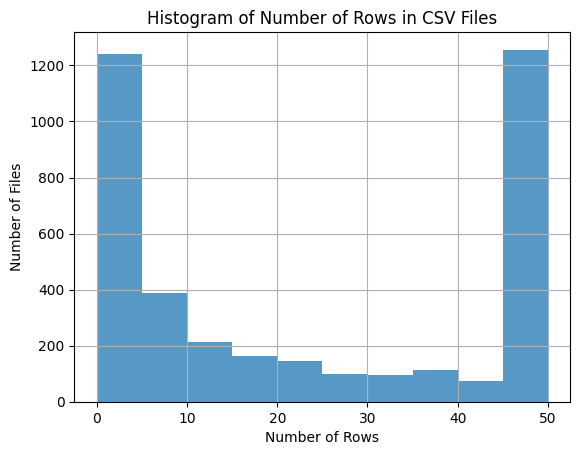

In [5]:
num_rows_list = []

for file in csv_files:
    df = pd.read_csv(file)
    num_rows_list.append(df.shape[0])

max_rows = max(num_rows_list)
min_rows = min(num_rows_list)

interval_size = 5
num_bins = np.ceil((max_rows - min_rows) / interval_size)

plt.hist(num_rows_list, bins=int(num_bins), alpha=0.75)

plt.title('Histogram of Number of Rows in CSV Files')
plt.xlabel('Number of Rows')
plt.ylabel('Number of Files')

plt.grid(True)
plt.show()

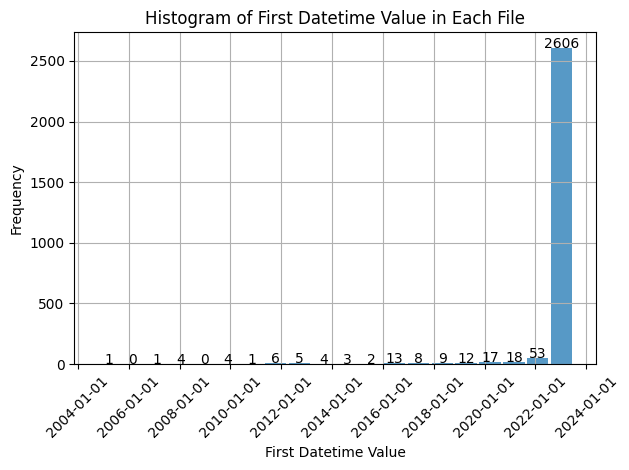

In [16]:
import matplotlib.dates as mdates
import datetime

date_index_beginning_value_list = []

# iterate over the list of csv files
for fname in csv_files:

    # read the csv file
    df = pd.read_csv(fname)

    if df.shape[0] == 0:
        # if the file is empty, ignore and continue
        continue
    val = df.iloc[0, 0] # first value in the first row

    date_index_beginning_value_list.append(val)

dates = [datetime.datetime.strptime(date_str, '%Y-%m-%d') for date_str in date_index_beginning_value_list]

# Convert list of datetime.date objects to matplotlib date numbers
date_nums = mdates.date2num(dates)

# Create histogram using numpy.histogram()
counts, bin_edges = np.histogram(date_nums, bins=20)

# Get bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram using matplotlib.pyplot.bar()
plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9, alpha=0.75)

# Format the x-axis to handle datetime objects
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Set locator to auto

plt.title('Histogram of First Datetime Value in Each File')
plt.xlabel('First Datetime Value')
plt.ylabel('Frequency')

plt.grid(True)

# Rotate the x-ticks for better visualization
plt.xticks(rotation=45)

# Write the counts above the bars
for i, count in enumerate(counts):
    plt.text(bin_centers[i], count, str(count), ha='center')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [81]:
# preprocessing - remove files with less than 8 rows
csv_files = [file for file in csv_files if pd.read_csv(file).shape[0] >= 8]
print(f"Number of files: {len(csv_files)}")

Number of files: 2311


In [74]:
print(f"Number of files: {len(csv_files)}")

Number of files: 0


In [61]:
# count files with empty values in second column
def count_empty_values_in_second_column(file):
    df = pd.read_csv(file)
    cnt = 0
    for val in df.iloc[:, 1]:
        if val == ' ':
            cnt += 1
    return cnt

# preprocessing - fill missing values with previous values
cnt = 0
for file in csv_files:
    df = pd.read_csv(file)
    df.fillna(method='ffill', inplace=True)
    # df.to_csv(file, index=False)
    cnt += count_empty_values_in_second_column(file)

print(f"Number of files with empty values in second column: {cnt}")

Number of files with empty values in second column: 0
Number of files with empty values in second column: 0


In [90]:
# preprocessing - get files that have each of eight values in second column less than 5
def get_files_with_less_than_5_values_in_second_column():
    files = []
    for file in csv_files:
        df = pd.read_csv(file)
        has_less_than_5 = True
        for val in df.iloc[:, 1]:
            if val > 2:
                has_less_than_5 = False
                break
        if has_less_than_5:
           files.append(file)
    return files

files = get_files_with_less_than_5_values_in_second_column()
print(files[:10])
print(f"Number of files with each of eight values in second column less than 5: {len(files)}")

['../dataset/altman-z-score/preprocessed\\AAL.csv', '../dataset/altman-z-score/preprocessed\\ABCB.csv', '../dataset/altman-z-score/preprocessed\\ACER.csv', '../dataset/altman-z-score/preprocessed\\ACNB.csv', '../dataset/altman-z-score/preprocessed\\ADMA.csv', '../dataset/altman-z-score/preprocessed\\ADV.csv', '../dataset/altman-z-score/preprocessed\\ADXN.csv', '../dataset/altman-z-score/preprocessed\\AEHL.csv', '../dataset/altman-z-score/preprocessed\\AEP.csv', '../dataset/altman-z-score/preprocessed\\AEZS.csv']
Number of files with each of eight values in second column less than 5: 561


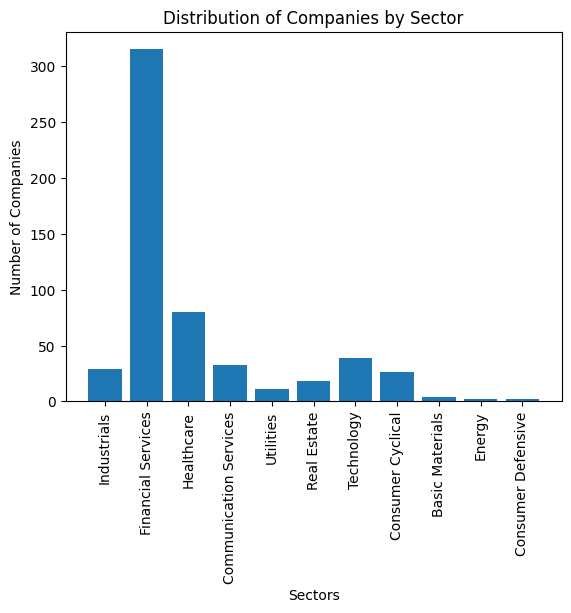

In [99]:
# fetch from yfinance info about companies?? which info
def get_file_name(file):
    return file.split('\\')[-1].split('.')[0]

sectors = {}

for file in files:
    try:
        ticker = get_file_name(file)
        company = yf.Ticker(ticker)
        info = company.info
        sector = info['sector']

        if sector in sectors:
            sectors[sector] += 1
        else:
            sectors[sector] = 1
    except KeyError:
        continue

# Create a histogram from the sectors dictionary
plt.bar(sectors.keys(), sectors.values())
plt.title('Distribution of Companies by Sector')
plt.xlabel('Sectors')
plt.ylabel('Number of Companies')
plt.xticks(rotation='vertical')  # Rotate x-axis labels for readability
plt.show()


In [98]:
# plot each file on one plot